# INF8775 – Analyse et conception d’algorithmes
# TP1 – Automne 2024

NOM, Prénom, 1234567

NOM, Prénom, 1234567

Note finale: 

<u>**Date limite de remise :**</u>  1er Octobre 23h59 (Groupe B2), 8 Octobre 23h59 (Groupe B1)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaison). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème classique de trier une liste de nombres aléatoires.

La taille de la liste ainsi que le nombre maximal permi changeront d'un échantillon à l'autre. Vous pouvez utilisez le code fourni pour générer plus d'instances, mais on fournit aussi des instances intéressantes pour pousser votre réflexion plus loin.

## Algorithmes à implanter

On vous demande de résoudre ce problème de 5 façons différentes :

1. En utilisant un algorithme simple: `Bubble Sort` ;
2. En utilisant une amélioration de l'algorithme précédent: `Cocktail Shaker Sort` ;
3. En utilisant un algorithme diviser pour régner: `Merge Sort` ;
4. En utilisant l'algorithme précédent avec un seuil de récursivité non élémentaire ;
5. En utilisant un algorithme non comparatif: `Radix Sort`.

Pour l’algorithme 4, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est inférieure à ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 2.

Pour l'algorithme 5, on vous demande de comparer les chiffres les moins significatifs en premier (`Radix Sort LDS`).


## Jeu de données

La classe Problem existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une liste d'une taille donnée contenant des nombres entre 1 et le maximum permis. Vous pouvez utilisez des listes aléatoires pour tester votre code.

In [17]:
import random
from collections.abc import Iterable

class Problem():
    def __init__(self, size: int, max_number: int, num_samples: int = 5) -> None:
        self.size = size
        self.max_number = max_number
        self.num_samples = num_samples
    
    def generate_sample(self) -> list[int]:
        """Returns a list of the given size containing numbers between 1 and the max_number"""
        return [random.randint(1,self.max_number) for _ in range(self.size)]
    
    def generate_dataset(self) -> Iterable[list[int]]:
        """Returns an iterator over as many samples as are described """
        return (self.generate_sample() for _ in range(self.num_samples))

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [18]:
import matplotlib.pyplot as plt
import time
from collections.abc import Callable
from math import log10
from scipy.stats import linregress

class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")

class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, max_number: int, mean: int) -> None:
        self.size = size
        self.max_number = max_number
        self.mean = mean

def convert_list_to_dict(original: list[int]) -> dict[int:int]:
    """Converts a list into a dictionary of frequencies"""
    freq: dict[int:int] = dict()
    for iter in original:
        if iter not in freq.keys():
            freq[iter] = 0
        freq[iter] += 1
    return freq

def is_valid_solution(original: list[int], solution: list[int]) -> bool:
    """Validates both if the solution is sorted and if the list was not modified"""
    # Lists must be of equal length
    if len(solution) != len(original):
        return False
    
    # List must be in increasing order
    for i in range(1, len(solution)):
        if solution[i-1] > solution[i]:
            return False
    
    original_freq = convert_list_to_dict(original)
    solution_freq = convert_list_to_dict(solution)
    # Lists must have the same values
    for key in original_freq.keys():
        if key not in solution_freq.keys() or\
            solution_freq[key] != original_freq[key]:
            return False
    
    # Solution is valid
    return True

def make_problems(sizes: list[int], max_numbers: list[int], num_samples: int = 5) -> list[Problem]:
    """Creates problem instances using given sizes and max_numbers"""
    problems: list[Problem] = []
    for size in sizes:
        for max_number in max_numbers:
            problems.append(Problem(size,max_number,num_samples))
    return problems

def measure(procedure: Callable[[list[int]],list[int]], sample: list[int], time_scale: int = 1000) -> int:
    """Returns the time in milliseconds taken to run the procedure.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    return round(end - start)

def measure_mean(procedure: Callable[[list[int]],list[int]], prob: Problem, time_scale: int = 1000) -> Measure:
    """Generates multiple samples with the specified parameters and returns the mean time in milliseconds

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    mean_time = sum(
        [measure(procedure,sample,time_scale) for sample in prob.generate_dataset()]
    ) / prob.num_samples
    return Measure(prob.size, prob.max_number, mean_time)

def measure_range(procedure: Callable[[list[int]],list[int]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken in milliseconds for each size in the given list.
    Uses a fixed max_number to measure the effect of size on its own.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    
    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time.
    """
    return [
        measure_mean(procedure, prob, time_scale)
        for prob in problems
    ]

def test_threshold(
    procedure: Callable[[list[int],int],list[int]],
    thresholds: list[int], problem: Problem, time_scale: int = 1000
) -> dict[int,int]:
    """Tests the different thresholds on the same problem instance."""
    threshold_measures = {t:0 for t in thresholds}
    for sample in problem.generate_dataset():
        for t in thresholds:
            start = time.time() * time_scale
            solution = procedure(sample,t)
            end = time.time() * time_scale
            if not is_valid_solution(sample,solution):
                raise InvalidSolution()
            threshold_measures[t] += (end - start) / problem.num_samples
    return threshold_measures

def estimate_threshold(
    first_data: dict[int,int],
    second_data: dict[int,int],
    first_label: str,
    second_label: str,
    y_label: str
):
    plt.plot(list(first_data.keys()),list(first_data.values()),label=first_label)
    plt.plot(list(second_data.keys()),list(second_data.values()),label=second_label)
    plt.xlabel('Taille')
    plt.ylabel(y_label)
    plt.title('Estimation du seuil')
    plt.show()

def display_threshold_measures(data: dict[int,int]):
    """Displays a graph of the time take to solve in regards to the chosen threshold"""
    x = list(data.keys())
    y = list(data.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps (ms)')
    plt.title('Selection du seuil')
    plt.show()
     
def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <12} {: <12} {: <12}".format("Taille", "Nombre maximal", "Temps moyen (ms)"))
    for measure in measures:
        print("{: <12} {: <12} {: <12}".format(measure.size, measure.max_number, measure.mean))

### The different tests are below, the names are in french to avoid confusion

def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())
    
    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(x, y)
    
    # Estimate the values of y based on the lin regression results
    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')
    
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def test_de_constantes(
    data: dict[int,int],
    x_label: str,
    y_label: str = "Temps (ms)",
    title: str = "Test de constantes"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme simple (Bubble Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri bubble sort.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [98]:
def bubble_sort(original: list[int]) -> list[int]:
    echange_effectue = True
    debut = 0
    def echange(liste, index1, index2):
        valeur = liste[index1]
        liste[index1] = liste[index2]
        liste[index2] = valeur

    l = len(original)
    while echange_effectue:
        echange_effectue = False
        for j in range(l-debut-1):
            if original[j] > original[j+1]:
                echange(original, j, j+1)
                echange_effectue = True
        debut += 1
    return original

In [99]:
for _ in range(10):
    exemple = [random.randint(1,10) for _ in range(10)]
    print(is_valid_solution(exemple, bubble_sort(exemple)))

True
True
True
True
True
True
True
True
True
True


<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Veuillez justifier.

La complexité asymptotique théorique de l'algorithme est en O(n^2). (n la taille de la lite à trier)
En effet, dans le pire des cas (liste strictement décroissante), on va faire n*(n-1)/2 opérations environ.

### Mesures

Pour cet algorithme ainsi que les prochains, vous devez choisir les différentes tailles de liste que vous voulez tester. Choisissez des tailles qui ont des résultats intéressants, une taille de 5 qui se termine en une fraction de millisecondes n'est pas le meilleur résultat pour faire des comparaisons.

Pour faire des mesures, utilisez la fonction `measure_range`. Elle permet de faire des mesures sur une liste de problèmes. Vous pouvez facilement créer des problèmes en utilisant la fonction `make_problems`. Ne faites varier que la taille <u>**OU**</u> le nombre maximal pour observer le comportement d'un des deux paramètres. Le code fournit s'occupera de générer des échantillons aléatoires, de calculer le temps moyen et de vous retourner une liste de mesures. Vous pouvez utilisez la fonction `range` de python pour obtenir une grande liste et avoir plusieurs points (faites attention au temps d'exécution).

Ces données peuvent ensuite être passées aux fonctions `test_de_...` en les mettant dans un `dict` python tel que `x:y`. Les tests ont de la documentation pour expliquer leur utilisation en plus de détails.

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [93]:
list_problems = make_problems(range(100, 10000, 500),[10])
list_measure = measure_range(bubble_sort, list_problems)

In [94]:
display_data_as_table(list_measure)

Taille       Nombre maximal Temps moyen (ms)
100          10           0.6         
600          10           12.0        
1100         10           39.6        
1600         10           83.6        
2100         10           144.6       
2600         10           220.8       
3100         10           312.2       
3600         10           421.8       
4100         10           548.0       
4600         10           696.6       
5100         10           843.2       
5600         10           1021.0      
6100         10           1211.4      
6600         10           1446.0      
7100         10           1666.8      
7600         10           1897.8      
8100         10           2163.2      
8600         10           2439.4      
9100         10           2743.8      
9600         10           3067.6      


### Analyse Hybride

In [149]:
import numpy as np
dict_measure = dict([(measure.size, measure.mean) for measure in list_measure])
dict_measure_puissance = dict([(np.log(measure.size), np.log(measure.mean)) for measure in list_measure])
dict_measure_rapport = dict([(measure.size**2, measure.mean) for measure in list_measure])
dict_measure_constantes = dict([(measure.size**2, measure.mean) for measure in list_measure])


/tmp/ipykernel_27296/4279606421.py:3: RuntimeWarning: divide by zero encountered in log
  dict_measure_puissance = dict([(np.log(measure.size), np.log(measure.mean)) for measure in list_measure])


#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

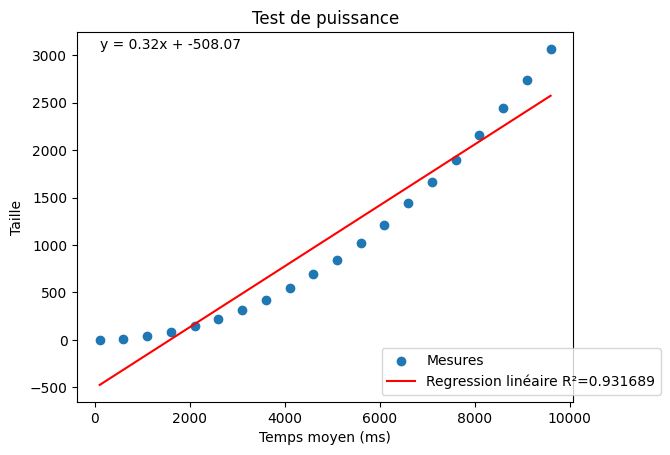

In [101]:
test_de_puissance(dict_measure, "Temps moyen (ms)", "Taille")

/usagers1/amtri/.local/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


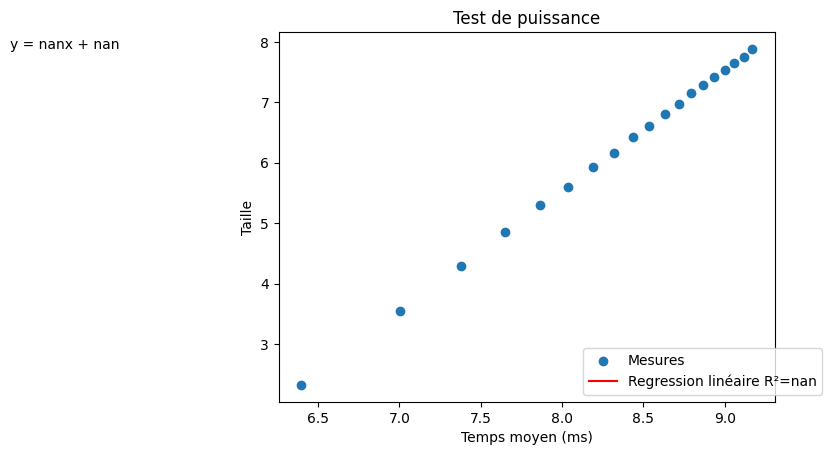

In [142]:
test_de_puissance(dict_measure_puissance, "Temps moyen (ms)", "Taille")

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

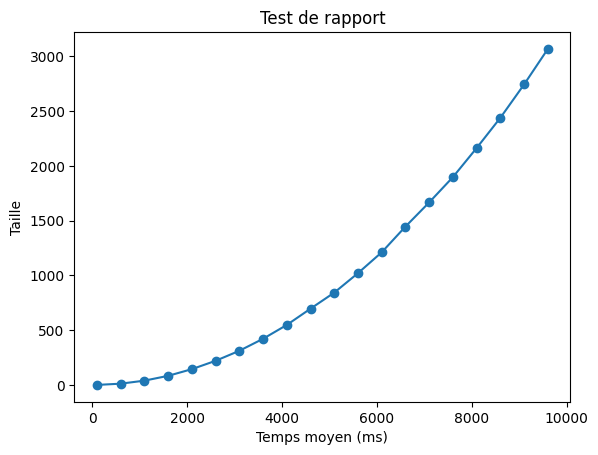

In [102]:
test_de_rapport(dict_measure, "Temps moyen (ms)", "Taille")

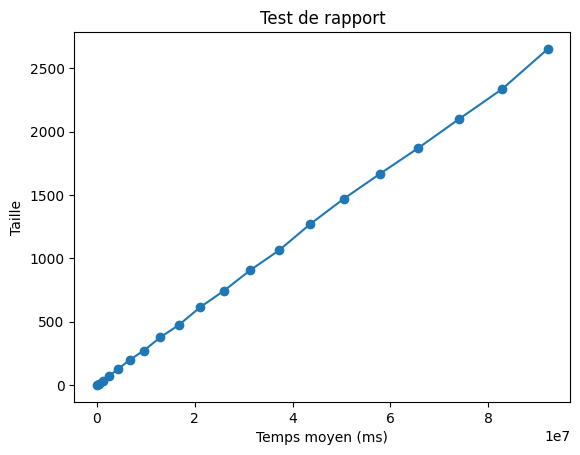

In [147]:
test_de_rapport(dict_measure_rapport, "Temps moyen (ms)", "Taille")

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

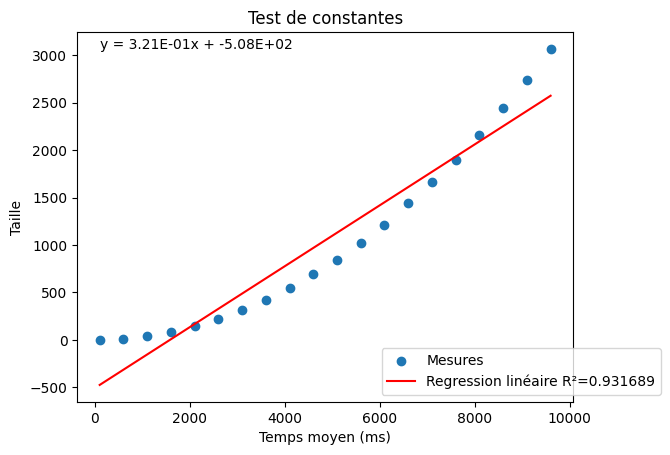

In [103]:
test_de_constantes(dict_measure, "Temps moyen (ms)", "Taille")

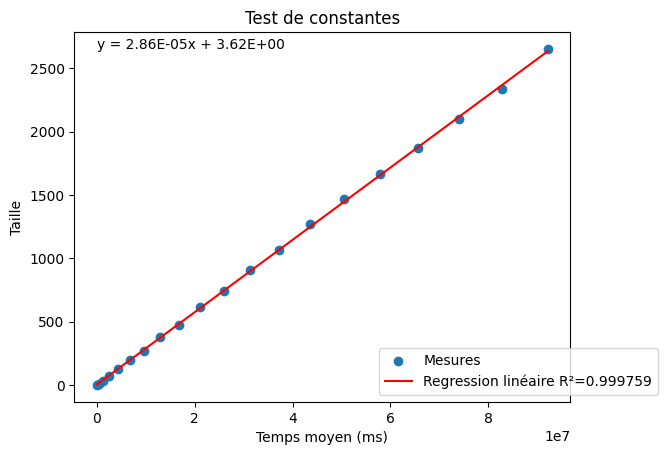

In [150]:
test_de_constantes(dict_measure_constantes, "Temps moyen (ms)", "Taille")

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

## Partie 2 : Algorithme ammélioré (Cocktail Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri cocktail sort.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [46]:
def cocktail_sort(original: list[int]) -> list[int]:
    l = len(original)
    echange_effectue = True
    debut = 0
    fin = l -1 
    def echange(liste, index1, index2):
        valeur = liste[index1]
        liste[index1] = liste[index2]
        liste[index2] = valeur

    
    while echange_effectue:
        echange_effectue = False

        for j in range(debut, fin):
            if original[j] > original[j+1]:
                echange(original, j, j+1)
                echange_effectue = True
        fin -= 1

        for j in range(fin, debut-1, -1):
            if original[j] > original[j+1]:
                echange(original, j, j+1)
                echange_effectue = True
        debut += 1
        
    return original

In [47]:
for _ in range(10):
    exemple = [random.randint(1,10) for _ in range(10)]
    print(is_valid_solution(exemple, cocktail_sort(exemple)))

True
True
True
True
True
True
True
True
True
True


<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Veuillez justifier.

La complexité asymptotique théorique de l'algorithme est en O(n^2). (n la taille de la lite à trier)
En effet, dans le pire des cas (liste strictement décroissante), on va faire n*(n-1)/2 opérations environ.

### Mesures

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [48]:
list_problems = make_problems(range(100, 10000, 500),[10])
list_measure = measure_range(cocktail_sort, list_problems)

In [49]:
display_data_as_table(list_measure)

Taille       Nombre maximal Temps moyen (ms)
100          10           0.2         
600          10           10.8        
1100         10           36.4        
1600         10           80.2        
2100         10           132.6       
2600         10           211.6       
3100         10           283.0       
3600         10           385.2       
4100         10           503.2       
4600         10           623.2       
5100         10           770.2       
5600         10           932.0       
6100         10           1102.4      
6600         10           1288.8      
7100         10           1448.8      
7600         10           1644.6      
8100         10           1875.0      
8600         10           2089.6      
9100         10           2333.2      
9600         10           2612.2      


### Analyse Hybride

In [50]:
dict_measure = dict([(measure.size, measure.mean) for measure in list_measure])

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

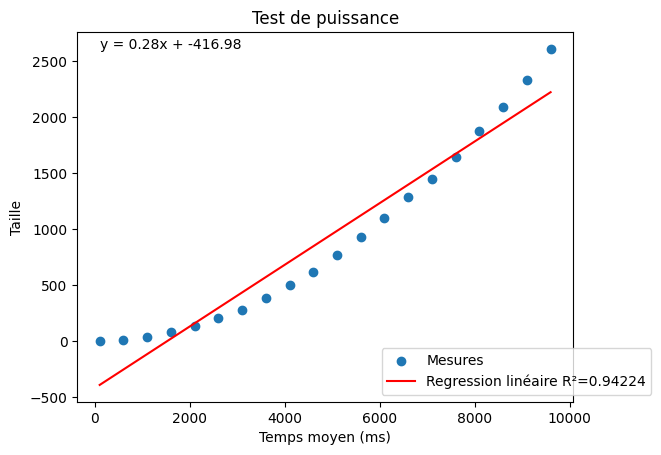

In [51]:
test_de_puissance(dict_measure, "Temps moyen (ms)", "Taille")

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

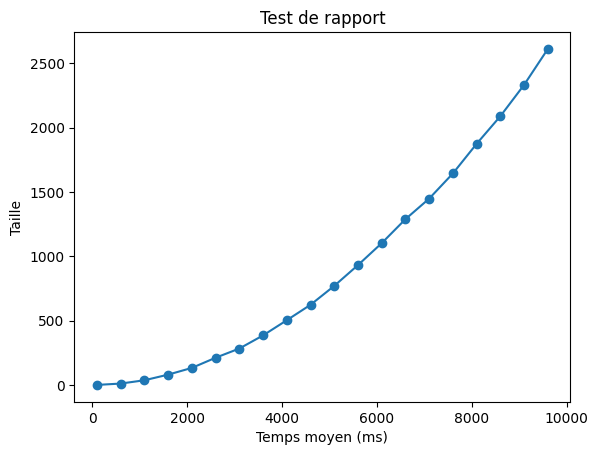

In [52]:
test_de_rapport(dict_measure, "Temps moyen (ms)", "Taille")

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

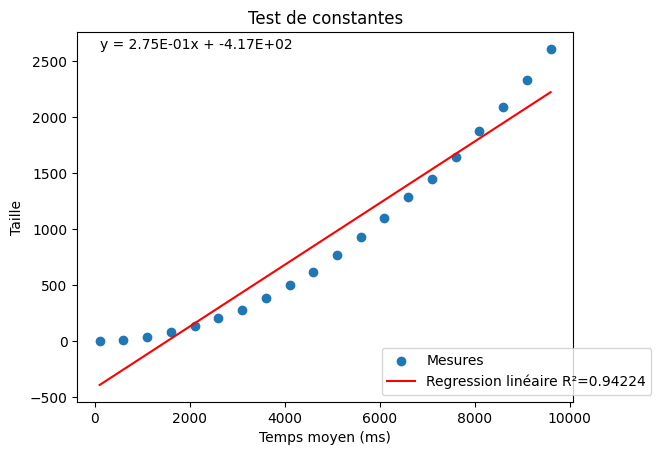

In [53]:
test_de_constantes(dict_measure, "Temps moyen (ms)", "Taille")

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

## Partie 3 : Algorithme diviser pour régner (Merge Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri merge sort. Cette algorithme utilise le patron de conception "Diviser pour régner".

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [34]:
def merge_sort(original: list[int]) -> list[int]:
    def decoupage(liste_base):
        l = len(liste_base)
        l1 = liste_base[0:int(l/2)]
        l2 = liste_base[int(l/2):l]
        return(l1,l2)

    def fusion(liste1, liste2):
        liste_fusion = []
        l1 = len(liste1)
        l2 = len(liste2)
        while l1>0 and l2 >0 :
            if liste1[0] <= liste2[0]:
                liste_fusion.append(liste1[0])
                liste1 = liste1[1:l1]
                l1 -= 1
            else:
                liste_fusion.append(liste2[0])
                liste2 = liste2[1:l2]
                l2 -= 1
        if l1 == 0:
            liste_fusion = liste_fusion + liste2
        else:
            liste_fusion = liste_fusion + liste1
        return liste_fusion
    if len(original) > 1 :
        original1, original2 = decoupage(original)
        original1 = merge_sort(original1)
        original2 = merge_sort(original2)
        original = fusion(original1, original2)
    return original

In [35]:
for _ in range(10):
    exemple = [random.randint(1,10) for _ in range(10)]
    print(is_valid_solution(exemple, merge_sort(exemple)))

True
True
True
True
True
True
True
True
True
True


<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Veuillez justifier.

Théorème maître : Complexité en O(nln(n)) (à justifier)

### Mesures

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [37]:
list_problems = make_problems(range(100, 10000, 500),[10])
list_measure = measure_range(merge_sort, list_problems)

In [38]:
display_data_as_table(list_measure)

Taille       Nombre maximal Temps moyen (ms)
100          10           0.0         
600          10           1.0         
1100         10           3.0         
1600         10           5.6         
2100         10           9.0         
2600         10           12.0        
3100         10           15.8        
3600         10           20.0        
4100         10           24.0        
4600         10           29.2        
5100         10           34.4        
5600         10           39.8        
6100         10           46.6        
6600         10           50.6        
7100         10           57.8        
7600         10           65.2        
8100         10           72.0        
8600         10           77.2        
9100         10           86.0        
9600         10           93.8        


### Analyse Hybride

In [39]:
dict_measure = dict([(measure.size, measure.mean) for measure in list_measure])

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

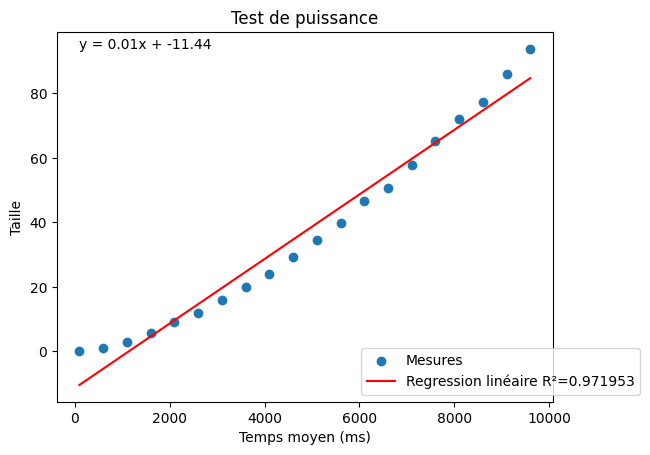

In [40]:
test_de_puissance(dict_measure, "Temps moyen (ms)", "Taille")

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

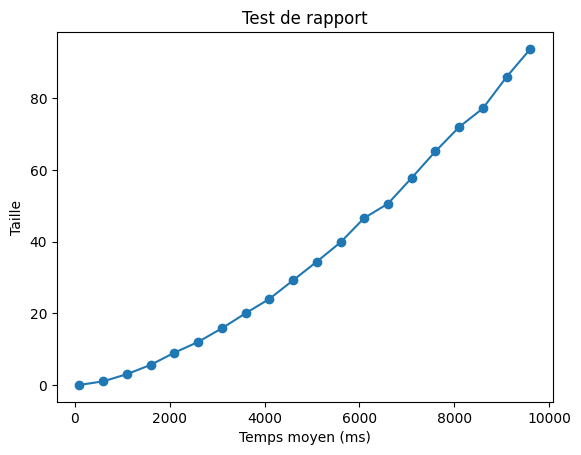

In [41]:
test_de_rapport(dict_measure, "Temps moyen (ms)", "Taille")

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

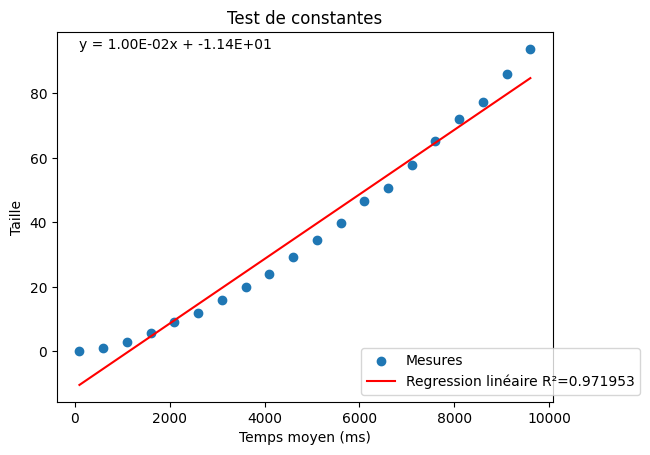

In [42]:
test_de_constantes(dict_measure, "Temps moyen (ms)", "Taille")

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

<u>**Question 4.c):**</u> Quel serait un meilleur choix de seuil? Utilisez la fonction `estimate_threshold` pour avoir une idée où commencer. Analysez le graph résultant et choisissez un seuil de départ.

On recommande de compiler des nouvelles données sur des tailles plus petites. Utilisez un `time_scale` plus grand pour avoir plus de détails (indiquez les unités dans le `y_label`). Une fois que vous avez une idée d'où se situe le point de croisement, vous pouvez refaire le test sur une sélection plus restreinte de tailles en augmentant `num_samples` pour avoir des résultats plus constants.

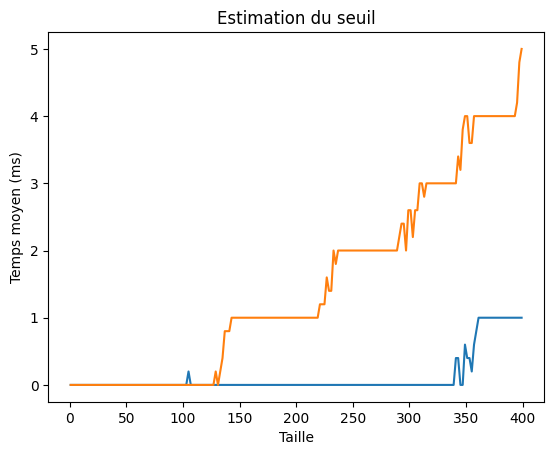

In [89]:
list_problems = make_problems(range(1, 400, 2),[1000])
list_measure_merge_sort = measure_range(merge_sort, list_problems)
list_measure_cocktail_sort = measure_range(cocktail_sort, list_problems)

dict_measure_merge_sort = dict([(measure.size, measure.mean) for measure in list_measure_merge_sort])
dict_measure_cocktail_sort = dict([(measure.size, measure.mean) for measure in list_measure_cocktail_sort])

estimate_threshold(dict_measure_merge_sort, dict_measure_cocktail_sort, "merge_sort", "cocktail_sort", "Temps moyen (ms)")


## Partie 4 : Algorithme diviser pour régner avec seuil arbitraire (Merge Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Reprenez l'algorithme précédent et modifiez-le pour y ajouter un seuil de récursivité. En dessous de ce seuil, vous utiliserez l'algorithme `cocktail_sort` écrit précédemment.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [43]:
def merge_sort_threshold(original: list[int], threshold: int = 1) -> list[int]:
    def decoupage(liste_base):
        l = len(liste_base)
        l1 = liste_base[0:int(l/2)]
        l2 = liste_base[int(l/2):l]
        return(l1,l2)

    def fusion(liste1, liste2):
        liste_fusion = []
        l1 = len(liste1)
        l2 = len(liste2)
        while l1>0 and l2 >0 :
            if liste1[0] <= liste2[0]:
                liste_fusion.append(liste1[0])
                liste1 = liste1[1:l1]
                l1 -= 1
            else:
                liste_fusion.append(liste2[0])
                liste2 = liste2[1:l2]
                l2 -= 1
        if l1 == 0:
            liste_fusion = liste_fusion + liste2
        else:
            liste_fusion = liste_fusion + liste1
        return liste_fusion
    if len(original) > threshold :
        original1, original2 = decoupage(original)
        original1 = merge_sort(original1)
        original2 = merge_sort(original2)
        original = fusion(original1, original2)
    else:
        original = cocktail_sort(original)
    return original

In [44]:
for _ in range(10):
    exemple = [random.randint(1,10) for _ in range(10)]
    print(is_valid_solution(exemple, merge_sort(exemple)))

True
True
True
True
True
True
True
True
True
True


<u>**Question 1.b):**</u> À l'aide de ce que vous avez vu dans la section précédente, effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux. Affichez les dans un graphique une fois que les mesures sont compilées. La fonction `test_threshold` vous sera utile pour faire ces tests. Choisissez bien vos seuils ainsi qu'une taille de liste permettant de bien observer la différence de performance.

In [103]:
problem = Problem(2000,100, 20)
list_thresholds = range(1, 1000, 10)
list_threshold_measures = test_threshold(merge_sort_threshold, list_thresholds, problem) 

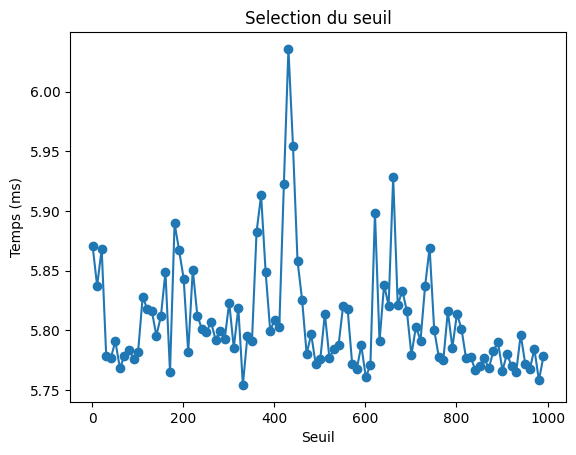

In [104]:
display_threshold_measures(list_threshold_measures)

<u>**Question 1.c):**</u> Quel est le seuil de récursivité le plus judicieux? Sur quel critère l'avez vous sélectionné? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances?

Changez le seuil par défaut de votre fonction au meilleur choix. Ceci vous permettra d'utiliser les fonctions utilitaires sans passer le seuil comme argument.

<u>**Question 1.d):**</u> La complexité asymptotique théorique de cet algorithme a-t-elle changée? Veuillez justifier.

### Mesures

<u>**Question 1.e):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [ ]:
# TODO take measurements

In [ ]:
# TODO Display data as tables

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

In [ ]:
# TODO Test de puissance

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

In [ ]:
# TODO Test de rapport

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

In [ ]:
# TODO Test des constantes

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?

## Partie 5 : Algorithme non comparatif (Radix Sort LSD) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri radix sort. Cette algorithme ne fait pas de comparaison entre les différents éléments de la liste.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [ ]:
def radix_sort(original: list[int]) -> list[int]:
    nbre_dec = len(str(max(origninal)))
    for i in range(nbre_dec):
        
    return original

In [105]:
max([15,21,684,8498,684,7497,49797,979,749])

49797

In [107]:
len(str(49797))

5

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Veuillez justifier.

<u>**Question 1.c):**</u> Comment cet algorithme ce distingue-t-il des algorithmes précédents? Est-ce toujours un avantage? Expliquez.

### Mesures

<u>**Question 1.d):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [ ]:
# TODO take measurements

In [ ]:
# TODO Display data as tables

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

In [ ]:
# TODO Test de puissance

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

In [ ]:
# TODO Test de rapport

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

In [ ]:
# TODO Test des constantes

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces algorithmes.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -2 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.